# Count the number of algorithm evaluations each model had

In [1]:
import pandas as pd

data = pd.read_csv('sklearn-benchmark5-data-edited.tsv.gz', sep='\t', names=['dataset',
                                                                     'classifier',
                                                                     'parameters',
                                                                     'accuracy', 
                                                                     'macrof1',
                                                                     'bal_accuracy']).fillna('')

data = data.groupby(['classifier', 'dataset', 'parameters'])['accuracy'].mean().reset_index()
data.groupby('classifier')['parameters'].count()

classifier
AdaBoostClassifier                5775
BernoulliNB                      23100
DecisionTreeClassifier           25410
ExtraTreesClassifier            126605
GaussianNB                         165
GradientBoostingClassifier      769900
KNeighborsClassifier              8831
LogisticRegression               39145
MultinomialNB                     3300
PassiveAggressiveClassifier       7260
RandomForestClassifier          126602
SGDClassifier                  4258362
SVC                             143179
Name: parameters, dtype: int64

# Rank the parameters for each model

In [1]:
import pandas as pd

data = pd.read_csv('sklearn-benchmark5-data-edited.tsv.gz', sep='\t', names=['dataset',
                                                                     'classifier',
                                                                     'parameters',
                                                                     'accuracy', 
                                                                     'macrof1',
                                                                     'bal_accuracy']).fillna('')

data = data.groupby(['classifier', 'dataset', 'parameters'])['accuracy'].mean().reset_index()
data['accuracy'] = data['accuracy'].apply(lambda x: round(x, 3))

In [2]:
# find data set SVM did not finish on
svm_data = data[data['classifier']=='SVC']
print([problem for problem,d in data.groupby('dataset') if problem not in svm_data['dataset'].unique()])

print('number of data sets in svm_data:',len(svm_data['dataset'].unique()))
print('number of data sets:',len(data['dataset'].unique()))
print('svm missing ',[p for p in data['dataset'].unique() if p not in svm_data['dataset'].unique()])

[]
number of data sets in svm_data: 165
number of data sets: 165
svm missing  []


In [3]:
from collections import defaultdict
from tqdm import tqdm
import numpy as np

model_param_ranks = defaultdict(list)

for dataset, group_dataset in tqdm(data.groupby('dataset')):
    num_scores = float(len(group_dataset['accuracy'].unique()))
    accuracy_ranks = {}
    
    for rank, accuracy in enumerate(sorted(group_dataset['accuracy'].unique(), reverse=True)):
        accuracy_ranks[accuracy] = (rank + 1) / num_scores
    
    for index, row in group_dataset.iterrows():
        model_param_ranks['{}-{}'.format(row['classifier'],
                                         row['parameters'])].append(accuracy_ranks[row['accuracy']])

100%|██████████| 165/165 [05:54<00:00,  2.22s/it]


In [4]:
model_average_param_ranks = defaultdict(float)
for model_param in model_param_ranks:
    model_average_param_ranks[model_param] = np.mean(model_param_ranks[model_param])

## Best params for each model from rankings

In [5]:
models_seen = set()

for model_param in sorted(model_average_param_ranks, key=model_average_param_ranks.get, reverse=False):
    model = model_param.split('-')[0]
    if model not in models_seen:
        models_seen.add(model)
    else:
        continue

    print('{}\t{}'.format(round(model_average_param_ranks[model_param], 3), model_param))
    
    if len(models_seen) >= 15:
        break

0.093	RandomForestClassifier-n_estimators=500,min_weight_fraction_leaf=0.0,max_features=None,criterion=entropy
0.096	GradientBoostingClassifier-loss=deviance,learning_rate=0.1,n_estimators=100,max_depth=5,max_features=0.5
0.098	ExtraTreesClassifier-n_estimators=500,min_weight_fraction_leaf=0.0,max_features=0.75,criterion=entropy
0.111	SVC-C=100.0,gamma=0.01,kernel=rbf,degree=2,coef0=0.0,
0.165	KNeighborsClassifier-n_neighbors=14,weights=distance
0.168	DecisionTreeClassifier-min_weight_fraction_leaf=0.0,max_features=None,criterion=entropy
0.186	LogisticRegression-C=1.0,penalty=l1,fit_intercept=True,dual=False,
0.203	SGDClassifier-loss=log,penalty=elasticnet,alpha=1e-05,learning_rate=invscaling,fit_intercept=True,l1_ratio=1.0,eta0=1.0,power_t=0.5
0.216	PassiveAggressiveClassifier-C=0.001,loss=squared_hinge,fit_intercept=True
0.232	AdaBoostClassifier-learning_rate=0.5,n_estimators=500
0.313	BernoulliNB-alpha=0.1,fit_prior=True,binarize=0.5
0.336	GaussianNB-
0.343	MultinomialNB-alpha=0.1,f

## Average each model parameter's rankings

In [6]:
from collections import defaultdict
import numpy as np

model_param_breakdown_rankings = defaultdict(lambda: defaultdict(lambda: defaultdict(list)))

for model_param in model_average_param_ranks:
    model = model_param.split('-')[0]
    if model == 'GaussianNB':
        continue
    params = '-'.join(model_param.split('-')[1:])
    params = params.split(',')
    rank = model_average_param_ranks[model_param]
    for param in params:
        model_param_breakdown_rankings[model][param.split('=')[0]][param.split('=')[-1]].append(rank)

model_param_breakdown_average_rankings = defaultdict(lambda: defaultdict(lambda: defaultdict(float)))

for model in sorted(model_param_breakdown_rankings):
    for param in model_param_breakdown_rankings[model]:
        for param_val in model_param_breakdown_rankings[model][param]:
            model_param_breakdown_average_rankings[model][param][param_val] = round(np.mean(
                model_param_breakdown_rankings[model][param][param_val]), 3)

In [7]:
for model in sorted(model_param_breakdown_average_rankings):
    print(model)
    print('--------------------')
    for param in model_param_breakdown_average_rankings[model]:
        print(param)
        for param_val in sorted(model_param_breakdown_average_rankings[model][param],
                                key=model_param_breakdown_average_rankings[model][param].get):
            print('\t={}{}{}'.format(param_val,
                                   (' ' * 25)[:25 - len(param_val)],
                                   model_param_breakdown_average_rankings[model][param][param_val]))
            
    print('')

AdaBoostClassifier
--------------------
learning_rate
	=0.5                      0.238
	=0.1                      0.248
	=1.0                      0.269
	=0.01                     0.278
	=50.0                     0.686
	=100.0                    0.715
	=10.0                     0.803
n_estimators
	=1000                     0.453
	=500                      0.453
	=100                      0.458
	=50                       0.464
	=10                       0.484

BernoulliNB
--------------------
alpha
	=10.0                     0.423
	=5.0                      0.425
	=25.0                     0.428
	=1.0                      0.431
	=0.75                     0.432
	=0.5                      0.433
	=0.25                     0.434
	=50.0                     0.434
	=0.1                      0.436
	=0.0                      0.714
fit_prior
	=True                     0.434
	=False                    0.484
binarize
	=0.5                      0.382
	=0.25                     0.396
	=0.75          

# Rank each model on a per-data set basis

In [8]:
import pandas as pd

data = pd.read_csv('sklearn-benchmark5-data-edited.tsv.gz', sep='\t', names=['dataset',
                                                                     'classifier',
                                                                     'parameters',
                                                                     'accuracy', 
                                                                     'macrof1',
                                                                     'bal_accuracy']).fillna('')

data = data.groupby(['classifier', 'dataset', 'parameters'])['accuracy'].mean().reset_index()
data['accuracy'] = data['accuracy'].apply(lambda x: round(x, 3))

In [9]:
from collections import defaultdict
from tqdm import tqdm
import numpy as np

model_ranks = defaultdict(list)

for dataset, group_dataset in tqdm(data.groupby('dataset')):
    if len(group_dataset['classifier'].unique()) != 14:
        continue
    
    num_scores = float(len(group_dataset['accuracy'].unique()))
    accuracy_ranks = {}
    
    for rank, accuracy in enumerate(sorted(group_dataset['accuracy'].unique(), reverse=True)):
        accuracy_ranks[accuracy] = (rank + 1) / num_scores
    
    for index, row in group_dataset.iterrows():
        model_ranks[row['classifier']].append(accuracy_ranks[row['accuracy']])

100%|██████████| 165/165 [00:00<00:00, 410.63it/s]


In [10]:
model_average_ranks = defaultdict(float)
for model in model_ranks:
    model_average_ranks[model] = np.mean(model_ranks[model])

In [11]:
for model in sorted(model_average_ranks, key=model_average_ranks.get, reverse=False):
    print('{}\t{}'.format(round(model_average_ranks[model], 3), model))

# How often is model X better than model Y?

In [11]:
import pandas as pd
import pdb

data = pd.read_csv('sklearn-benchmark5-data-edited.tsv.gz', sep='\t', names=['dataset',
                                                                     'classifier',
                                                                     'parameters',
                                                                     'accuracy', 
                                                                     'macrof1',
                                                                     'bal_accuracy']).fillna('')

data = data.groupby(['dataset','classifier'])['accuracy'].max().reset_index()
data['accuracy'] = data['accuracy'].apply(lambda x: round(x, 3))
data.head()

,dataset,classifier,accuracy
0,GAMETES_Epistasis_2-Way_1000atts_0.4H_EDM-1_ED...,AdaBoostClassifier,0.502
1,GAMETES_Epistasis_2-Way_1000atts_0.4H_EDM-1_ED...,BernoulliNB,0.504
2,GAMETES_Epistasis_2-Way_1000atts_0.4H_EDM-1_ED...,DecisionTreeClassifier,0.532
3,GAMETES_Epistasis_2-Way_1000atts_0.4H_EDM-1_ED...,ExtraTreesClassifier,0.552
4,GAMETES_Epistasis_2-Way_1000atts_0.4H_EDM-1_ED...,GaussianNB,0.499


In [12]:
from collections import defaultdict
from tqdm import tqdm
import numpy as np
from itertools import combinations
import pdb

model_tourneys = defaultdict(int)
all_models = sorted(data['classifier'].unique())

for dataset, group_dataset in tqdm(data.groupby('dataset')):
    
#     pdb.set_trace()
    group_dataset.loc[:, 'accuracy']= group_dataset['accuracy'].values / group_dataset['accuracy'].max()
    group_dataset = group_dataset.set_index('classifier')['accuracy'].to_dict()

    for (model1, model2) in combinations(group_dataset.keys(), 2):
        if group_dataset[model1] >= group_dataset[model2] + 0.01:
            model_tourneys[(model1, model2)] += 1
        elif group_dataset[model2] >= group_dataset[model1] + 0.01:
            model_tourneys[(model2, model1)] += 1

  0%|          | 0/166 [00:00<?, ?it/s]/Users/randal_olson/anaconda/lib/python3.6/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
100%|██████████| 166/166 [00:09<00:00, 18.18it/s]


In [13]:
from itertools import product

for model1 in all_models:
    print('{}{}W / L'.format(model1,
                               ' ' * (38 - len(model1))))
    print('--------------------')
    for model2 in all_models:
        if model1 == model2:
            continue
        print('\t{}{}{} / {}'.format(model2,
                                     ' ' * (30 - len(model2)),
                                     model_tourneys[(model1, model2)],
                                     model_tourneys[(model2, model1)]))
    print('')

AdaBoostClassifier                    W / L
--------------------
	BernoulliNB                   98 / 25
	DecisionTreeClassifier        53 / 71
	ExtraTreesClassifier          24 / 105
	GaussianNB                    126 / 19
	GradientBoostingClassifier    2 / 126
	KNeighborsClassifier          57 / 74
	LogisticRegression            65 / 58
	MultinomialNB                 127 / 23
	PassiveAggressiveClassifier   77 / 47
	RandomForestClassifier        12 / 114
	SGDClassifier                 49 / 73
	SVC                           17 / 102

BernoulliNB                           W / L
--------------------
	AdaBoostClassifier            25 / 98
	DecisionTreeClassifier        29 / 114
	ExtraTreesClassifier          7 / 133
	GaussianNB                    103 / 37
	GradientBoostingClassifier    0 / 148
	KNeighborsClassifier          21 / 116
	LogisticRegression            37 / 89
	MultinomialNB                 113 / 22
	PassiveAggressiveClassifier   42 / 82
	RandomForestClassifier        3 / 140
	S

In [14]:
from itertools import product
import numpy as np

model_tourney_matrix = []

for pair in list(product(all_models, all_models)):
    model_tourney_matrix.append(model_tourneys[pair])
    
model_tourney_matrix = np.array(model_tourney_matrix).reshape((13, 13))
all_models = list(np.array(all_models)[np.argsort(model_tourney_matrix.sum(axis=1))[::-1]])
model_tourney_matrix = model_tourney_matrix[:, np.argsort(model_tourney_matrix.sum(axis=1))[::-1]]

In [15]:
from itertools import product
import numpy as np

model_tourney_matrix = []

for pair in list(product(all_models, all_models)):
    model_tourney_matrix.append(model_tourneys[pair])
    
model_tourney_matrix = np.array(model_tourney_matrix).reshape((13, 13))
all_models = list(np.array(all_models)[np.argsort(model_tourney_matrix.sum(axis=1))[::-1]])
model_tourney_matrix = model_tourney_matrix[:, np.argsort(model_tourney_matrix.sum(axis=1))[::-1]]

''

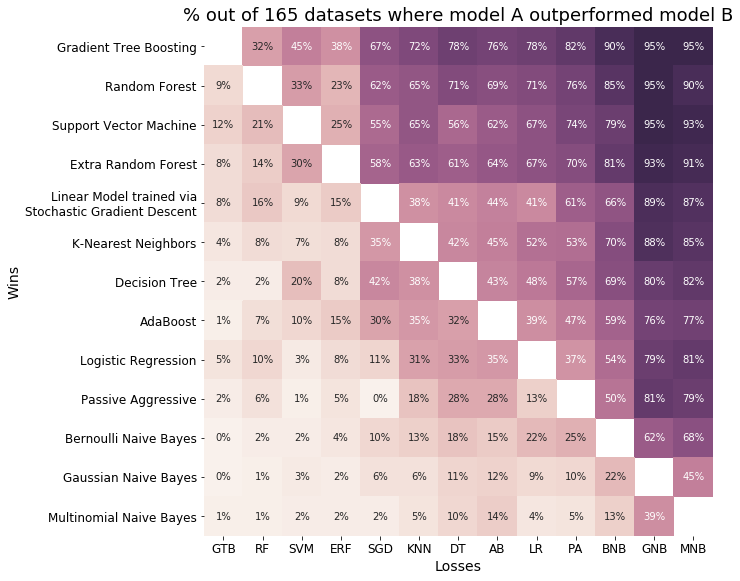

In [74]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sb
model_nice_dict = {
    'AdaBoostClassifier': 'AB',
    'BernoulliNB': 'BNB',
    'LogisticRegression': 'LR',
    'MultinomialNB': 'MNB',
    'PassiveAggressiveClassifier': 'PA',
    'SGDClassifier': 'SGD',
    'GaussianNB': 'GNB',
    'DecisionTreeClassifier': 'DT',
    'ExtraTreesClassifier': 'ERF',
    'RandomForestClassifier': 'RF',
    'GradientBoostingClassifier':'GTB',
    'KNeighborsClassifier': 'KNN',
    'SVC': 'SVM'
}
model_nice_dict_y = {
    'AdaBoostClassifier': 'AdaBoost',
    'BernoulliNB': 'Bernoulli Naive Bayes',
    'LogisticRegression': 'Logistic Regression',
    'MultinomialNB': 'Multinomial Naive Bayes',
    'PassiveAggressiveClassifier': 'Passive Aggressive',
    'SGDClassifier': 'Linear Model trained via\nStochastic Gradient Descent',
    'GaussianNB': 'Gaussian Naive Bayes',
    'DecisionTreeClassifier': 'Decision Tree',
    'ExtraTreesClassifier': 'Extra Random Forest',
    'RandomForestClassifier': 'Random Forest',
    'GradientBoostingClassifier':'Gradient Tree Boosting',
    'KNeighborsClassifier': 'K-Nearest Neighbors',
    'SVC': 'Support Vector Machine'
}

model_nice = []
model_nice_y = []
for m in all_models:
    model_nice.append(model_nice_dict[m])
    model_nice_y.append(model_nice_dict_y[m])

mask_matrix = []
for x in range(len(model_nice_dict)):
    for y in range(len(model_nice_dict)):
        mask_matrix.append(x == y)
mask_matrix = np.array(mask_matrix).reshape(13, 13)

plt.figure(figsize=(10, 10))
sb.heatmap(np.round(model_tourney_matrix / 165., 2), fmt='0.0%',
           mask=mask_matrix,
           cmap=sb.cubehelix_palette(500, light=0.95, dark=0.15),
           square=True, annot=True, vmin=0., vmax=1.0,
           xticklabels=model_nice, yticklabels=model_nice_y, cbar=False)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Losses', fontsize=14)
plt.ylabel('Wins', fontsize=14)
plt.title('% out of 165 datasets where model A outperformed model B', fontsize=18)
h = plt.gcf()
plt.tight_layout()
h.savefig('figs/model_outperformance.pdf', bbox_inches='tight')
#plt.savefig('figures/sklearn-model-x-outperform-model-y.pdf', bbox_inches='tight')
;

# How many models do we need to cover all data sets?

In [9]:
import pandas as pd
import pdb

data = pd.read_csv('sklearn-benchmark5-data-edited.tsv.gz', sep='\t', names=['dataset',
                                                                     'classifier',
                                                                     'parameters',
                                                                     'accuracy', 
                                                                     'macrof1',
                                                                     'bal_accuracy']).fillna('')

data = data.groupby(['dataset','classifier'])['accuracy'].max().reset_index()
data['accuracy'] = data['accuracy'].apply(lambda x: round(x, 3))
data.head()

,dataset,classifier,accuracy
0,GAMETES_Epistasis_2-Way_1000atts_0.4H_EDM-1_ED...,AdaBoostClassifier,0.502
1,GAMETES_Epistasis_2-Way_1000atts_0.4H_EDM-1_ED...,BernoulliNB,0.504
2,GAMETES_Epistasis_2-Way_1000atts_0.4H_EDM-1_ED...,DecisionTreeClassifier,0.532
3,GAMETES_Epistasis_2-Way_1000atts_0.4H_EDM-1_ED...,ExtraTreesClassifier,0.552
4,GAMETES_Epistasis_2-Way_1000atts_0.4H_EDM-1_ED...,GaussianNB,0.499


In [10]:
from collections import defaultdict
from tqdm import tqdm
import numpy as np

dataset_best_models = defaultdict(list)
model_counts = defaultdict(int)

for dataset, group_dataset in data.groupby('dataset'):
    group_dataset['accuracy'] /= group_dataset['accuracy'].max()
    dataset_best_models[dataset] = group_dataset.loc[
        group_dataset['accuracy'] >= 0.99, 'classifier'].values

for dataset in dataset_best_models:
    for model in dataset_best_models[dataset]:
        model_counts[model] += 1
print('Model','&','Data Set Coverage','\\\\ \\hline')
for model in sorted(model_counts, key=model_counts.get, reverse=True):
    print(model,'&',model_counts[model],'\\\\')

/Users/randal_olson/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


Model & Data Set Coverage \\ \hline
GradientBoostingClassifier & 126 \\
RandomForestClassifier & 90 \\
ExtraTreesClassifier & 84 \\
SVC & 79 \\
SGDClassifier & 43 \\
AdaBoostClassifier & 30 \\
DecisionTreeClassifier & 30 \\
LogisticRegression & 26 \\
KNeighborsClassifier & 24 \\
PassiveAggressiveClassifier & 21 \\
BernoulliNB & 14 \\
MultinomialNB & 6 \\
GaussianNB & 5 \\


In [11]:
dataset_best_models = defaultdict(list)
model_counts = defaultdict(int)

for dataset, group_dataset in data.groupby('dataset'):
    group_dataset['accuracy'] /= group_dataset['accuracy'].max()
    dataset_best_models[dataset] = group_dataset.loc[
        group_dataset['accuracy'] >= 0.99, 'classifier'].values

for dataset in dataset_best_models:
    for model in dataset_best_models[dataset]:
        model_counts[model] += 1

dataset_exclude_set = set()
top_models = []

while len(dataset_exclude_set) != len(data['dataset'].unique()):
    next_top_model = sorted(model_counts, key=model_counts.get, reverse=True)[0]
    top_models.append((model_counts[next_top_model], next_top_model))
    
    for dataset in dataset_best_models:
        if next_top_model in dataset_best_models[dataset]:
            dataset_exclude_set.add(dataset)

    dataset_best_models = defaultdict(list)
    model_counts = defaultdict(int)
    
    for dataset, group_dataset in data.groupby('dataset'):
        if dataset in dataset_exclude_set:
            continue
        group_dataset['accuracy'] /= group_dataset['accuracy'].max()
        dataset_best_models[dataset] = group_dataset.loc[
            group_dataset['accuracy'] >= 0.99, 'classifier'].values
        
    for dataset in dataset_best_models:
        for model in dataset_best_models[dataset]:
            model_counts[model] += 1

/Users/randal_olson/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/Users/randal_olson/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [12]:
top_models

[(126, 'GradientBoostingClassifier'),
 (22, 'SVC'),
 (8, 'RandomForestClassifier'),
 (4, 'ExtraTreesClassifier'),
 (2, 'SGDClassifier'),
 (1, 'LogisticRegression'),
 (1, 'MultinomialNB'),
 (1, 'DecisionTreeClassifier'),
 (1, 'AdaBoostClassifier')]

# How many model-parameter combinations do we need to cover all data sets?

In [42]:
import pandas as pd
import pdb

data = pd.read_csv('sklearn-benchmark5-data-edited.tsv.gz', sep='\t', names=['dataset',
                                                                     'classifier',
                                                                     'parameters',
                                                                     'accuracy', 
                                                                     'macrof1',
                                                                     'bal_accuracy']).fillna('')

data = data.groupby(['dataset','classifier','parameters'])['accuracy'].max().reset_index()
data = data[data['classifier']!='LinearSVC']
data['classifier-params'] = data['classifier'].values + '-' + data['parameters'].values
data['accuracy'] = data['accuracy'].apply(lambda x: round(x, 3))
data.head()

,dataset,classifier,parameters,accuracy,classifier-params
0,GAMETES_Epistasis_2-Way_1000atts_0.4H_EDM-1_ED...,AdaBoostClassifier,"learning_rate=0.01,n_estimators=10",0.479,"AdaBoostClassifier-learning_rate=0.01,n_estima..."
1,GAMETES_Epistasis_2-Way_1000atts_0.4H_EDM-1_ED...,AdaBoostClassifier,"learning_rate=0.01,n_estimators=100",0.477,"AdaBoostClassifier-learning_rate=0.01,n_estima..."
2,GAMETES_Epistasis_2-Way_1000atts_0.4H_EDM-1_ED...,AdaBoostClassifier,"learning_rate=0.01,n_estimators=1000",0.488,"AdaBoostClassifier-learning_rate=0.01,n_estima..."
3,GAMETES_Epistasis_2-Way_1000atts_0.4H_EDM-1_ED...,AdaBoostClassifier,"learning_rate=0.01,n_estimators=50",0.484,"AdaBoostClassifier-learning_rate=0.01,n_estima..."
4,GAMETES_Epistasis_2-Way_1000atts_0.4H_EDM-1_ED...,AdaBoostClassifier,"learning_rate=0.01,n_estimators=500",0.496,"AdaBoostClassifier-learning_rate=0.01,n_estima..."


In [ ]:
from collections import defaultdict 

dataset_best_models = defaultdict(list)
model_counts = defaultdict(int)

for dataset, group_dataset in data.groupby('dataset'):
    group_dataset.loc[:, 'accuracy'] = group_dataset['accuracy'].values / group_dataset['accuracy'].max()
    dataset_best_models[dataset] = group_dataset.loc[
        group_dataset['accuracy'] >= 0.99, 'classifier-params'].values

for dataset in dataset_best_models:
    for model in dataset_best_models[dataset]:
        model_counts[model] += 1

dataset_exclude_set = set()
top_models = []

while len(dataset_exclude_set) != len(data['dataset'].unique()):
    next_top_model = sorted(model_counts, key=model_counts.get, reverse=True)[0]
    top_models.append((model_counts[next_top_model], next_top_model))
    
    if len(top_models) == 5:
        break
    
    # Don't allow repeat models
    data = data.loc[data['classifier'] != next_top_model.split('-')[0].strip()]
    
    for dataset in dataset_best_models:
        if next_top_model in dataset_best_models[dataset]:
            dataset_exclude_set.add(dataset)

    dataset_best_models = defaultdict(list)
    model_counts = defaultdict(int)
    
    for dataset, group_dataset in data.groupby('dataset'):
        if dataset in dataset_exclude_set:
            continue
        group_dataset.loc[:, 'accuracy'] = group_dataset.loc[:, 'accuracy'].values / group_dataset['accuracy'].max()
        dataset_best_models[dataset] = group_dataset.loc[
            group_dataset['accuracy'] >= 0.99, 'classifier-params'].values
        
    for dataset in dataset_best_models:
        for model in dataset_best_models[dataset]:
            model_counts[model] += 1

In [44]:
top_models

[(51,
  'GradientBoostingClassifier-loss=deviance,learning_rate=0.1,n_estimators=500,max_depth=3,max_features=log2'),
 (19,
  'RandomForestClassifier-n_estimators=500,min_weight_fraction_leaf=0.0,max_features=0.25,criterion=entropy'),
 (16, 'SVC-C=0.01,gamma=0.1,kernel=poly,degree=3,coef0=10.0,'),
 (12,
  'ExtraTreesClassifier-n_estimators=1000,min_weight_fraction_leaf=0.0,max_features=log2,criterion=entropy'),
 (8, 'LogisticRegression-C=16.5,penalty=l1,fit_intercept=True,dual=False,')]

In [54]:
[(x, model_counts[x]) for x in sorted(model_counts, key=model_counts.get, reverse=True)[:25]]

[('LogisticRegression-C=16.5,penalty=l1,fit_intercept=True,dual=False,', 8),
 ('LogisticRegression-C=17.5,penalty=l1,fit_intercept=True,dual=False,', 8),
 ('LogisticRegression-C=18.0,penalty=l1,fit_intercept=True,dual=False,', 8),
 ('LogisticRegression-C=18.5,penalty=l1,fit_intercept=True,dual=False,', 8),
 ('LogisticRegression-C=19.0,penalty=l1,fit_intercept=True,dual=False,', 8),
 ('LogisticRegression-C=19.5,penalty=l1,fit_intercept=True,dual=False,', 8),
 ('LogisticRegression-C=20.0,penalty=l1,fit_intercept=True,dual=False,', 8),
 ('LogisticRegression-C=1.5,penalty=l1,fit_intercept=True,dual=False,', 8),
 ('AdaBoostClassifier-learning_rate=0.01,n_estimators=1000', 8),
 ('LogisticRegression-C=10.0,penalty=l2,fit_intercept=True,dual=False,', 8),
 ('LogisticRegression-C=12.0,penalty=l2,fit_intercept=True,dual=True,', 7),
 ('LogisticRegression-C=15.0,penalty=l2,fit_intercept=True,dual=True,', 7),
 ('LogisticRegression-C=15.5,penalty=l2,fit_intercept=True,dual=True,', 7),
 ('LogisticRegr

# Model/data biclustering analysis

Create matrix of data sets vs. best model accuracy on those data sets.

Cluster the matrix.





In [26]:
import pandas as pd


data = pd.read_csv('sklearn-benchmark5-data-edited.tsv.gz', sep='\t', names=['dataset',
                                                                     'classifier',
                                                                     'parameters',
                                                                     'accuracy', 
                                                                     'macrof1',
                                                                     'bal_accuracy']).fillna('')

data = data.groupby(['classifier', 'dataset'])['bal_accuracy'].max().reset_index()
# print("classifiers before drop:",data['classifier'].unique())
# data = data[data['classifier']!='LinearSVC']
# data = data[data['classifier']!='SVC']
print('loaded ',data['dataset'].unique().shape[0],'datasets and ', data['classifier'].unique().shape[0],'classifiers')
# data['classifier-params'] = data['classifier'].values + '-' + data['parameters'].values
data['bal_accuracy'] = data['bal_accuracy'].apply(lambda x: round(x, 3))

loaded  165 datasets and  13 classifiers


In [27]:
import numpy as np
from tqdm import tqdm
from sklearn.cluster.bicluster import SpectralBiclustering
from sklearn.metrics import consensus_score
import matplotlib.pyplot as plt
%matplotlib inline
import pdb
# get model results with best parameters 

all_models = np.asarray((data['classifier'].unique()))
all_datasets = np.asarray((data['dataset'].unique()))
model_data_acc = np.zeros([len(all_models),len(all_datasets)])
model_data_acc_norm = np.zeros([len(all_models),len(all_datasets)])

ranks = np.zeros([len(all_models),len(all_datasets)])
#print("model_data_acc.shape:",model_data_acc.shape)
# all_models = []
for i,(clf, group_clf) in enumerate(tqdm(data.groupby('dataset'))):
    print('clf:',clf)
    data_acc  = group_clf['bal_accuracy'].transpose()
    model_data_acc[:,i] = data_acc
#     model_data_acc_norm[:,i] = (data_acc-data_acc.min())/(data_acc.max() - data_acc.min())
    model_data_acc_norm[:,i] = (data_acc-data_acc.mean())

#     all_models.append(clf)
    
all_models = np.asarray(all_models)
# get ranks
for i,mda in enumerate(model_data_acc.transpose()):
    #print("mda shape:",mda.shape)
    temp = mda.argsort()
    ranks[temp,i] = np.arange(len(mda))
np.savetxt('figs/ranks',ranks)
np.savetxt('figs/model_data_accuracy',model_data_acc)


print("clustering...")
np.random.seed(42)
model = SpectralBiclustering(n_clusters=(4,10), random_state=0)
model.fit(model_data_acc)
#score = consensus_score(model.biclusters_, (rows[:, row_idx], columns[:, col_idx]))

#print("consensus score: {:.3f}".format(score))
r = model.row_labels_[:]
c = model.column_labels_[:]
#rearrange data into biclusters
fit_data_norm = model_data_acc_norm[np.argsort(r)]
fit_data_norm = fit_data_norm[:, np.argsort(c)]

fit_data = model_data_acc[np.argsort(r)]
fit_data = fit_data[:, np.argsort(c)]

all_models = all_models[np.argsort(r)]
all_datasets = all_datasets[np.argsort(c)]
print('done')

  0%|          | 0/165 [00:00<?, ?it/s]

clf: GAMETES_Epistasis_2-Way_1000atts_0.4H_EDM-1_EDM-1_1
clf: GAMETES_Epistasis_2-Way_20atts_0.1H_EDM-1_1
clf: GAMETES_Epistasis_2-Way_20atts_0.4H_EDM-1_1
clf: GAMETES_Epistasis_3-Way_20atts_0.2H_EDM-1_1
clf: GAMETES_Heterogeneity_20atts_1600_Het_0.4_0.2_50_EDM-2_001
clf: GAMETES_Heterogeneity_20atts_1600_Het_0.4_0.2_75_EDM-2_001
clf: Hill_Valley_with_noise
clf: Hill_Valley_without_noise
clf: adult
clf: agaricus-lepiota
clf: allbp
clf: allhyper
clf: allhypo
clf: allrep
clf: analcatdata_aids
clf: analcatdata_asbestos
clf: analcatdata_authorship
clf: analcatdata_bankruptcy
clf: analcatdata_boxing1
clf: analcatdata_boxing2
clf: analcatdata_creditscore
clf: analcatdata_cyyoung8092
clf: analcatdata_cyyoung9302
clf: analcatdata_dmft
clf: analcatdata_fraud
clf: analcatdata_germangss
clf: analcatdata_happiness
clf: analcatdata_japansolvent
clf: analcatdata_lawsuit
clf: ann-thyroid
clf: appendicitis
clf: australian
clf: auto
clf: backache
clf: balance-scale
clf: banana
clf: biomed
clf: breast
c

100%|██████████| 165/165 [00:00<00:00, 1920.21it/s]


vowel
clf: waveform-21
clf: waveform-40
clf: wdbc
clf: wine-quality-red
clf: wine-quality-white
clf: wine-recognition
clf: xd6
clf: yeast
clustering...
done


biclusters_: 2


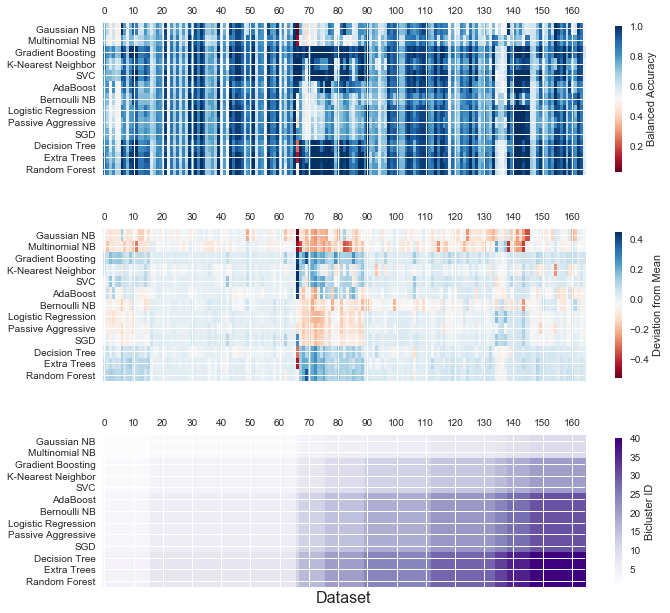

cluster 1 :
"phoneme","analcatdata_boxing2","GAMETES_Epistasis_2-Way_20atts_0.4H_EDM-1_1","analcatdata_boxing1","GAMETES_Heterogeneity_20atts_1600_Het_0.4_0.2_50_EDM-2_001","GAMETES_Heterogeneity_20atts_1600_Het_0.4_0.2_75_EDM-2_001","collins","spectf","connect-4","cars","monk3","corral","glass","prnn_fglass","movement_libras","auto", 
cluster 2 :
"haberman","german","heart-c","heart-h","flags","dna","GAMETES_Epistasis_2-Way_1000atts_0.4H_EDM-1_EDM-1_1","crx","credit-g","credit-a","contraceptive","colic","cmc","dermatology","hepatitis","mfeat-factors","led24","wine-recognition","tokyo1","titanic","spect","solar-flare_2","saheart","promoters","profb","hungarian","postoperative-patient-data","molecular-biology_promoters","mfeat-zernike","mfeat-pixel","mfeat-karhunen","mfeat-fourier","cleveland-nominal","lymphography","led7","optdigits","cleveland","heart-statlog","analcatdata_asbestos","analcatdata_dmft","breast-w","buggyCrx","analcatdata_cyyoung9302","breast","breast-cancer","cleve","ba

In [28]:
model_nice_dict = {
    'AdaBoostClassifier': 'AdaBoost',
    'BernoulliNB': 'Bernoulli NB',
    'LinearSVC': 'Linear SVC',
    'LogisticRegression': 'Logistic Regression',
    'MultinomialNB': 'Multinomial NB',
    'PassiveAggressiveClassifier': 'Passive Aggressive',
    'SGDClassifier': 'SGD',
    'GaussianNB': 'Gaussian NB',
    'DecisionTreeClassifier': 'Decision Tree',
    'ExtraTreesClassifier': 'Extra Trees',
    'RandomForestClassifier': 'Random Forest',
    'GradientBoostingClassifier':'Gradient Boosting',
    'KNeighborsClassifier': 'K-Nearest Neighbor',
    'SVC': 'SVC'
}
model_nice = []
for m in all_models:
    model_nice.append(model_nice_dict[m])
    
    
print("biclusters_:",len(model.biclusters_))
#plot
# h = plt.figure(figsize=(4,3),sharey=True)
# ax = plt.subplot(111)
h,ax = plt.subplots(3,figsize=(10,9))
# ax = h.add_subplot(311)
tmp = ax[0].imshow(fit_data[:,:],cmap=plt.cm.RdBu) 
# ax[0].set_title('A')
# ax[0].set_xlabel('A')
cbar=plt.colorbar(tmp,ax=ax[0],orientation='vertical',shrink=0.8)
cbar.set_label('Balanced Accuracy')
ax[0].set_yticks(range(len(all_models))) #,rotation=90
ax[0].set_yticklabels(model_nice) #,rotation=90
# ax[1].set_xlabel('Data Set',size=16)
ax[0].set_xticks(np.arange(len(all_datasets),step=10))
ax[0].xaxis.tick_top()

# h = plt.gcf()
# ax = plt.gca( )
ax[0].set_aspect(4)

# h.tight_layout()
# h = plt.gcf()

# h.savefig("figs/bicluster.pdf",dpi=100)

# k = plt.figure(figsize=(10,3))
# ax = h.add_subplot(312)
tmp = ax[1].matshow(fit_data_norm[:,:],cmap=plt.cm.RdBu) 

cbar=plt.colorbar(tmp,ax=ax[1],orientation='vertical',shrink=0.8)
cbar.set_label('Deviation from Mean')
ax[1].set_yticks(range(len(all_models))) #,rotation=90
ax[1].set_yticklabels(model_nice) #,rotation=90
# ax[1].set_xlabel('Data Set',size=16)
ax[1].set_xticks(np.arange(len(all_datasets),step=10))
# ax[1].set_xlabel('B')
# h = plt.gcf()
# ax = plt.gca( )
ax[1].set_aspect(4)
# h.tight_layout()
# h = plt.gcf()

# k.savefig("figs/bicluster_zeromean.pdf",dpi=100)


# h2 = plt.figure(figsize=(10,3))
# ax = h.add_subplot(313)
cluster_labels  = np.outer(np.sort(model.row_labels_) + 1,np.sort(model.column_labels_) + 1)
boundary = np.zeros((cluster_labels.shape[0],cluster_labels.shape[1]))
for i,cr in enumerate(cluster_labels[1:]):
    for j,cc in enumerate(cr[1:]):
        if cluster_labels[i-1,j] != cluster_labels[i,j]:
            boundary[i,j] = 1
        if cluster_labels[i,j-1] != cluster_labels[i,j]:
            boundary[i,j] = 1
            
tmp=ax[2].matshow(cluster_labels,cmap=plt.cm.Purples,alpha=1)
# tmp = 
# ydata = [0,165,0,165,0,165]
# tmp=ax[2].plot((0,165),(2.5,2.5))
# plt.gca().invert_yaxis()
cbar=plt.colorbar(tmp,ax=ax[2],orientation='vertical',shrink=0.8)
cbar.set_label('Bicluster ID')
plt.yticks(range(len(all_models)), model_nice) #,rotation=90
ax[2].set_xlabel('Dataset',size=16)
plt.xticks(np.arange(len(all_datasets),step=10))
# ax[2].set_xlabel('C')
# h = plt.gcf()
# ax = plt.gca( )
ax[2].set_aspect(4)
h.tight_layout()
# plt.subplots_adjust(top=0.95)
h.savefig("figs/cluster_all.pdf",dpi=100)
h.savefig("figs/cluster_all.eps",dpi=100)
h.savefig("figs/cluster_all.png",dpi=100)


plt.show()
j=0
for c in np.unique(cluster_labels[0,:]):
    print('cluster',c,':')
    for d in all_datasets[cluster_labels[0,:]==c]:
#         print('',j,":",d)
        print('"'+d+'"',end=',')
        j+=1
    print(' ')

# How do the algorithms cluster?

Create matrix of data sets vs. median model accuracy on those data sets.

Cluster the matrix using Agglomerative Clustering. Look at the resulting dendrogram.

In [29]:
import pandas as pd

data = pd.read_csv('sklearn-benchmark5-data-edited.tsv.gz', sep='\t', names=['dataset',
                                                                     'classifier',
                                                                     'parameters',
                                                                     'accuracy', 
                                                                     'macrof1',
                                                                     'bal_accuracy']).fillna('')

# data = data.groupby(['classifier', 'dataset', 'parameters'])['accuracy'].mean().reset_index()

In [30]:
import numpy as np
from tqdm import tqdm
from scipy.cluster import hierarchy
import matplotlib.pyplot as plt
%matplotlib inline

all_models = np.asarray(sorted(data['classifier'].unique()))
# remove SVC from all_models

all_datasets = np.asarray(sorted(data['dataset'].unique()))

model_data_acc = np.zeros([len(all_models),len(all_datasets)])
ranks = np.zeros([len(all_models),len(all_datasets)])
#print("model_data_acc.shape:",model_data_acc.shape)
all_models = []

for i,(clf, group_clf) in enumerate(tqdm(data.groupby('classifier'))):
#     if clf != 'SVC':
    model_best_params_acc = np.zeros(len(all_datasets))
    # find best parameter setings for model, based on median cv score for each parameter setting
    for params,group_clf_params in group_clf.groupby('parameters'):
        # across data sets
        for j,a in enumerate(group_clf_params.groupby('dataset')['accuracy'].median()):
            if a > model_best_params_acc[j]:
                model_best_params_acc[j] = a
    # model i's accuracy is the median cv accuracy of the best parameter settings for that model, across data sets
    model_data_acc[i,:] = model_best_params_acc

    all_models.append(clf)

all_models = np.asarray(all_models)

# get ranks
for i,mda in enumerate(model_data_acc.transpose()):
    #print("mda shape:",mda.shape)
    temp = mda.argsort()
    ranks[temp,i] = np.arange(len(mda))
    


100%|██████████| 13/13 [00:25<00:00,  4.43s/it]


clustering...


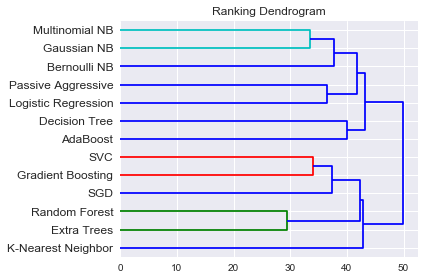

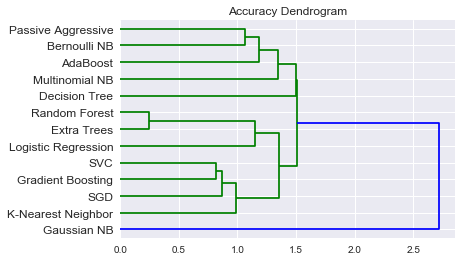

In [31]:
model_nice_dict = {
    'AdaBoostClassifier': 'AdaBoost',
    'BernoulliNB': 'Bernoulli NB',
    'LinearSVC': 'Linear SVC',
    'LogisticRegression': 'Logistic Regression',
    'MultinomialNB': 'Multinomial NB',
    'PassiveAggressiveClassifier': 'Passive Aggressive',
    'SGDClassifier': 'SGD',
    'GaussianNB': 'Gaussian NB',
    'DecisionTreeClassifier': 'Decision Tree',
    'ExtraTreesClassifier': 'Extra Trees',
    'RandomForestClassifier': 'Random Forest',
    'GradientBoostingClassifier':'Gradient Boosting',
    'KNeighborsClassifier': 'K-Nearest Neighbor',
    'SVC': 'SVC'
}
model_nice = []
for m in all_models:
    model_nice.append(model_nice_dict[m])
    
print("clustering...")
Z = hierarchy.linkage(ranks, 'single')
dn = hierarchy.dendrogram(Z, labels = model_nice, orientation='right')
plt.title('Ranking Dendrogram')
h = plt.gcf()
plt.figure(1,figsize=(6,4))
plt.tight_layout()
h.savefig('figs/HAC_models_ranking.pdf')

plt.figure()
Z = hierarchy.linkage(model_data_acc, 'single')
dn = hierarchy.dendrogram(Z, labels = model_nice, orientation='right')
plt.title('Accuracy Dendrogram')
h = plt.gcf()
plt.figure(1,figsize=(6,4))
plt.tight_layout()
h.savefig('figs/HAC_models_accuracy.pdf')
plt.show()

In [32]:
# How do the data sets cluster?

100%|██████████| 145/145 [00:30<00:00,  2.09it/s]


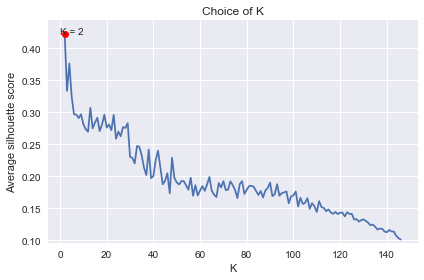

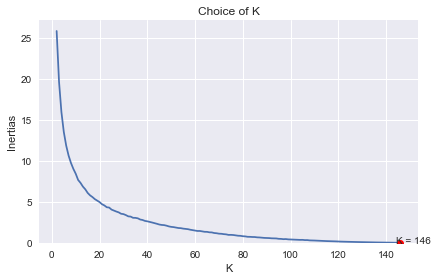

In [33]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.decomposition import PCA
import numpy
from tqdm import tqdm
#==========
# optimal K via elbow method with silhouette score which produces a better elbow.
#==========
X = model_data_acc.transpose()
Ks = np.arange(2,147,1)
Inertias = []
Silhouettes = []
np.random.seed(2)
# loop through k values
for K in tqdm(Ks):
	km = KMeans(n_clusters=K, init='k-means++',copy_x=False).fit(X)
	labels = km.labels_
	centers = km.cluster_centers_
	inertia = km.inertia_
	Silhouettes.append(silhouette_score(X,labels))
	# Inertias[K-1] = km.inertia_
	Inertias.append(km.inertia_)

# line plot of K versus Silhouette score with best value marked with x 
plt.figure(1)
plt.plot(Ks,Silhouettes,label='silhouette')
plt.plot(Ks[np.argmax(Silhouettes)],Silhouettes[np.argmax(Silhouettes)],marker = 'o',color='r',markersize=7)
plt.text(Ks[np.argmax(Silhouettes)]-2,Silhouettes[np.argmax(Silhouettes)],"K = "+repr(Ks[np.argmax(Silhouettes)]))
plt.ylim(0.95*np.min(Silhouettes),1.05*np.max(Silhouettes))
plt.ylabel("Average silhouette score") #Y-axis label
plt.xlabel("K") #X-axis label
plt.title("Choice of K") #Plot title
plt.tight_layout()
plt.savefig("figs/k_silhouette.pdf")

plt.figure(2)
plt.plot(Ks,Inertias,label='inertia')
plt.plot(Ks[np.argmin(Inertias)],Inertias[np.argmin(Inertias)],marker = 'o',color='r',markersize=7)
plt.text(Ks[np.argmin(Inertias)]-2,Inertias[np.argmin(Inertias)],"K = "+repr(Ks[np.argmin(Inertias)]))
plt.ylim(0.95*np.min(Inertias),1.05*np.max(Inertias))
plt.ylabel("Inertias") #Y-axis label
plt.xlabel("K") #X-axis label
plt.title("Choice of K") #Plot title
plt.tight_layout()
plt.savefig("figs/k_inertia.pdf")

/Users/randal_olson/anaconda/lib/python3.6/site-packages/matplotlib/lines.py:1206: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if self._markerfacecolor != fc:


col: [ 0.10588235  0.61960784  0.46666667  1.        ]
col: [ 0.45882353  0.43921569  0.70196078  1.        ]
col: [ 0.90196078  0.67058824  0.00784314  1.        ]
col: [ 0.4  0.4  0.4  1. ]


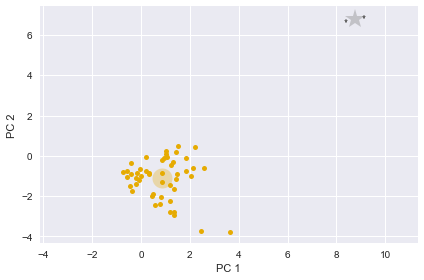

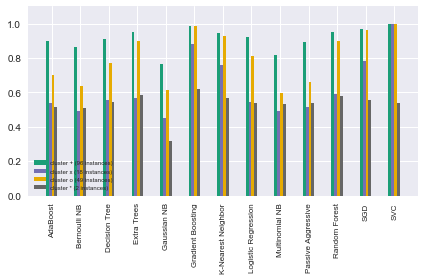

In [34]:
# =====
# plot cluster centers on 2 principal component axes
# =====
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import itertools
from sklearn.preprocessing import StandardScaler

marker =('+', 'x', 'o', '*','s','^','<','v','>') 
h = plt.figure()
ss = StandardScaler()
X = ss.fit_transform(model_data_acc.transpose())

pca = PCA(n_components = 2)
X_pca = pca.fit_transform(X)
nc=4
unique_classes = np.array((0,1,2,3)) 
km = KMeans(n_clusters=nc, init='k-means++',copy_x=False,random_state=0).fit(X)
labels = km.labels_
centers = km.cluster_centers_
unique_labels = np.unique(labels)
# centers_pca = centers
centers_pca = pca.transform(centers)
colors = plt.cm.Dark2(np.linspace(0, 1, len(unique_labels)))

for k, col in zip(unique_labels, colors):
    label_mask = (k==labels)
    xy = X_pca[label_mask]
    plt.plot(xy[:,0], xy[:, 1], linestyle = '', marker=marker[k%nc], markerfacecolor=col, markersize=5, alpha=1)

for k, col in zip(unique_labels, colors): 
     plt.plot(centers_pca[k,0],centers_pca[k,1], linestyle='', marker=marker[k%nc], markerfacecolor=col,markersize=20,alpha=0.3)

plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.tight_layout()
h.savefig('figs/k_means_PCA_data.pdf')

h2 = plt.figure()
features = model_nice
    
for k,col in zip(unique_labels,colors):
    label_mask = (k==labels)
    coverage = np.sum(label_mask)
    xk_mean = np.mean(ss.inverse_transform(X[label_mask]),axis=0)
    offset = k*0.1-np.mean(np.unique(labels))*0.1
    print('col:',col)
    plt.bar(np.arange(len(features))+offset,xk_mean,align='center',width=0.1,facecolor=col,label='cluster '+marker[k%nc]+' ('+str(coverage)+' instances)')

plt.ylim(0,1.1)
plt.gca().set_xticks(np.arange(len(features)))
plt.gca().set_xticklabels(list(features),fontsize=8,rotation=90)
plt.legend(loc=3,fontsize=6) #(bbox_to_anchor=(1.05, 1), 
plt.tight_layout()
h2.savefig('figs/data_ml_bar.pdf')

plt.show()

# Comparison of tuned to un-tuned results


In [18]:
import numpy as np
from tqdm import tqdm
import pandas as pd

data = pd.read_csv('sklearn-benchmark5-data-edited.tsv.gz', sep='\t', names=['dataset',
                                                                     'classifier',
                                                                     'parameters',
                                                                     'accuracy', 
                                                                     'macrof1',
                                                                     'bal_accuracy']).fillna('')

data = data.groupby(['classifier', 'dataset', 'parameters'])['accuracy'].mean().reset_index()
data['accuracy'] = data['accuracy'].apply(lambda x: round(x, 3))

In [19]:
clf_defaults_dict = {
    'GradientBoostingClassifier': 'loss=deviance,learning_rate=0.1,n_estimators=100,max_depth=3,max_features=None',
    'RandomForestClassifier': 'n_estimators=10,min_weight_fraction_leaf=0.0,max_features=sqrt,criterion=gini',
    'SVC': 'C=1.0,gamma=auto,kernel=rbf,degree=2,coef0=0.0,',
    'ExtraTreesClassifier': 'n_estimators=10,min_weight_fraction_leaf=0.0,max_features=sqrt,criterion=gini',
    'KNeighborsClassifier': 'n_neighbors=5,weights=uniform',
    'LogisticRegression': 'C=1.0,penalty=l2,fit_intercept=True,dual=False,',
    'DecisionTreeClassifier': 'min_weight_fraction_leaf=0.0,max_features=None,criterion=gini',
    'SGDClassifier': 'loss=hinge,penalty=l2,alpha=0.0001,learning_rate=optimal,fit_intercept=True,l1_ratio=0.15,eta0=0.0,power_t=0.5',
    'PassiveAggressiveClassifier': 'C=1.0,loss=hinge,fit_intercept=False',
    'AdaBoostClassifier': 'learning_rate=1.0,n_estimators=50',
    'BernoulliNB': 'alpha=1.0,fit_prior=True,binarize=0.0',
    'GaussianNB': '',
    'MultinomialNB': 'alpha=1.0,fit_prior=True'
}

default_params_list = ['-'.join([k, v]) for k, v in clf_defaults_dict.items()]

default_scores = data.loc[
    data.apply(
        lambda record: '-'.join([record['classifier'],
                                 record['parameters']]) in default_params_list,
        axis=1)].drop('parameters', axis=1)

best_scores = data.groupby(['dataset', 'classifier'])['accuracy'].max().reset_index()

In [20]:
merged_scores = default_scores.merge(best_scores,
                                     on=['classifier', 'dataset'],
                                     suffixes=['_default', '_best'])

merged_scores['accuracy_default_scaled'] = merged_scores['accuracy_best'] - merged_scores['accuracy_default']

model_names_dict = {
    'AdaBoostClassifier': 'AdaBoost',
    'BernoulliNB': 'Bernoulli Naive Bayes',
    'LogisticRegression': 'Logistic Regression',
    'MultinomialNB': 'Multinomial Naive Bayes',
    'PassiveAggressiveClassifier': 'Passive Aggressive',
    'SGDClassifier': 'Linear Model trained via\nStochastic Gradient Descent',
    'GaussianNB': 'Gaussian Naive Bayes',
    'DecisionTreeClassifier': 'Decision Tree',
    'ExtraTreesClassifier': 'Extra Random Forest',
    'RandomForestClassifier': 'Random Forest',
    'GradientBoostingClassifier':'Gradient Tree Boosting',
    'KNeighborsClassifier': 'K-Nearest Neighbors',
    'SVC': 'Support Vector Machine'
}

merged_scores['classifier'] = merged_scores['classifier'].apply(lambda x: model_names_dict[x])

merged_scores.head()

,classifier,dataset,accuracy_default,accuracy_best,accuracy_default_scaled
0,AdaBoost,GAMETES_Epistasis_2-Way_1000atts_0.4H_EDM-1_ED...,0.474,0.502,0.028
1,AdaBoost,GAMETES_Epistasis_2-Way_20atts_0.1H_EDM-1_1,0.480,0.506,0.026
2,AdaBoost,GAMETES_Epistasis_2-Way_20atts_0.4H_EDM-1_1,0.459,0.503,0.044
3,AdaBoost,GAMETES_Epistasis_3-Way_20atts_0.2H_EDM-1_1,0.518,0.526,0.008
4,AdaBoost,GAMETES_Heterogeneity_20atts_1600_Het_0.4_0.2_...,0.493,0.527,0.034


''

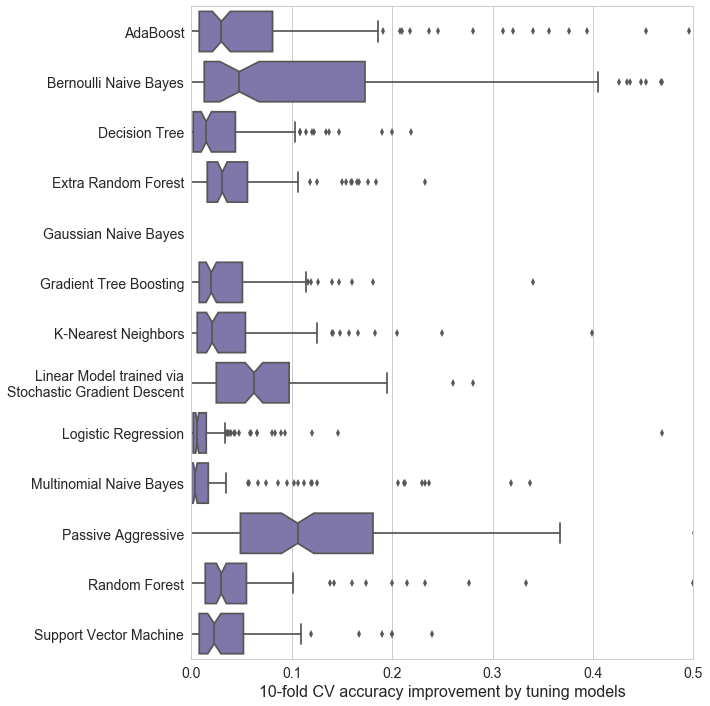

In [21]:
%matplotlib inline
import seaborn as sb
import matplotlib.pyplot as plt

sb.set_style('whitegrid')

plt.figure(figsize=(9, 12))
sb.boxplot(data=merged_scores.sort_values('classifier'),
           y='classifier', x='accuracy_default_scaled', notch=True,
           palette=[sb.color_palette('Purples', n_colors=2)[1]])
plt.ylabel('')
plt.xlabel('10-fold CV accuracy improvement by tuning models', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlim(0., 0.5)
#plt.title('Tuning machine learning model parameters almost always improves\nmodel performance', fontsize=22)
plt.savefig('figs/tuned_untuned_accuracy_boxplot.pdf', bbox_inches='tight')
;

# print model abbreviation table

In [39]:
model_nice_dict = {
    'AdaBoostClassifier': 'AB',
    'BernoulliNB': 'BNB',
    'LinearSVC': 'LSVC',
    'LogisticRegression': 'LR',
    'MultinomialNB': 'MNB',
    'PassiveAggressiveClassifier': 'PAC',
    'SGDClassifier': 'SGD',
    'GaussianNB': 'GNB',
    'DecisionTreeClassifier': 'DT',
    'ExtraTreesClassifier': 'ET',
    'RandomForestClassifier': 'RF',
    'GradientBoostingClassifier':'GB',
    'KNeighborsClassifier': 'KNN'
}
model_nice = []
for m in model_nice_dict:
    print(model_nice_dict)


    

{'AdaBoostClassifier': 'AB', 'BernoulliNB': 'BNB', 'LinearSVC': 'LSVC', 'LogisticRegression': 'LR', 'MultinomialNB': 'MNB', 'PassiveAggressiveClassifier': 'PAC', 'SGDClassifier': 'SGD', 'GaussianNB': 'GNB', 'DecisionTreeClassifier': 'DT', 'ExtraTreesClassifier': 'ET', 'RandomForestClassifier': 'RF', 'GradientBoostingClassifier': 'GB', 'KNeighborsClassifier': 'KNN'}
{'AdaBoostClassifier': 'AB', 'BernoulliNB': 'BNB', 'LinearSVC': 'LSVC', 'LogisticRegression': 'LR', 'MultinomialNB': 'MNB', 'PassiveAggressiveClassifier': 'PAC', 'SGDClassifier': 'SGD', 'GaussianNB': 'GNB', 'DecisionTreeClassifier': 'DT', 'ExtraTreesClassifier': 'ET', 'RandomForestClassifier': 'RF', 'GradientBoostingClassifier': 'GB', 'KNeighborsClassifier': 'KNN'}
{'AdaBoostClassifier': 'AB', 'BernoulliNB': 'BNB', 'LinearSVC': 'LSVC', 'LogisticRegression': 'LR', 'MultinomialNB': 'MNB', 'PassiveAggressiveClassifier': 'PAC', 'SGDClassifier': 'SGD', 'GaussianNB': 'GNB', 'DecisionTreeClassifier': 'DT', 'ExtraTreesClassifier': '

In [40]:
import pandas as pd

data = pd.read_csv('sklearn-benchmark5-data-edited.tsv.gz', sep='\t', names=['dataset',
                                                                     'classifier',
                                                                     'parameters',
                                                                     'accuracy', 
                                                                     'macrof1',
                                                                     'bal_accuracy']).fillna('')
data = data.groupby(['dataset','classifier'])['bal_accuracy'].max().reset_index()

print(data[:5])

                                             dataset              classifier  \
0  GAMETES_Epistasis_2-Way_1000atts_0.4H_EDM-1_ED...      AdaBoostClassifier   
1  GAMETES_Epistasis_2-Way_1000atts_0.4H_EDM-1_ED...             BernoulliNB   
2  GAMETES_Epistasis_2-Way_1000atts_0.4H_EDM-1_ED...  DecisionTreeClassifier   
3  GAMETES_Epistasis_2-Way_1000atts_0.4H_EDM-1_ED...    ExtraTreesClassifier   
4  GAMETES_Epistasis_2-Way_1000atts_0.4H_EDM-1_ED...              GaussianNB   

   bal_accuracy  
0      0.502500  
1      0.503750  
2      0.531875  
3      0.551875  
4      0.499375  


                                                    bal_accuracy
dataset                                                         
postoperative-patient-data                              0.522577
GAMETES_Epistasis_2-Way_20atts_0.1H_EDM-1_1             0.528319
analcatdata_dmft                                        0.539730
GAMETES_Heterogeneity_20atts_1600_Het_0.4_0.2_7...      0.542770
coil2000                                                0.557337
analcatdata_germangss                                   0.589339
cleveland-nominal                                       0.605934
cleveland                                               0.618177
wine-quality-red                                        0.624348
cloud                                                   0.632068
schizo                                                  0.634562
krkopt                                                  0.638377
cmc                                                     0.642090
Hill_Valley_without_noise

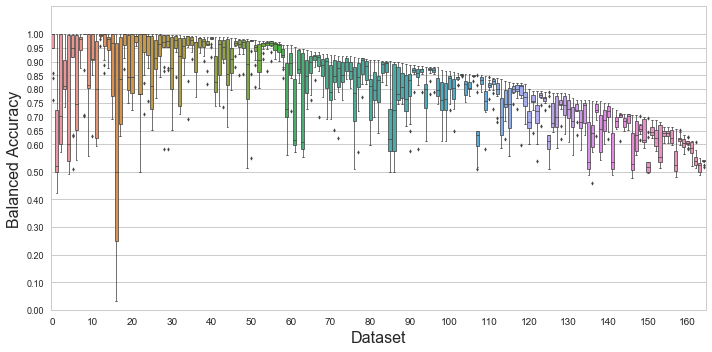

In [41]:
import seaborn as sns

datan = data.groupby(['dataset']).max().sort_values('bal_accuracy',ascending=False)
# print(datan)

datamv = data.groupby(['dataset']).median()+data.groupby(['dataset']).var()
datamv = datamv.sort_values('bal_accuracy',ascending=True)

# for i in datamv.index:
#     print(data[i,'bal_accuracy'])
print(datamv[::2])
# print(datan.index)

print(data['dataset'][:5])
plt.figure(figsize=(10,5))
sns.set_style("whitegrid")
s=sns.boxplot(data=data,x='dataset',y='bal_accuracy',order=datan.index,fliersize=3,linewidth=0.75)
s.set_xticks(np.arange(len(np.unique(data['dataset'])),step=10))
s.set_xticklabels(np.arange(len(np.unique(data['dataset'])),step=10))
yticks = np.hstack((np.arange(0.6,step=0.1),np.arange(0.6,1.05,step=0.05)))
s.set_yticks(yticks)
s.set_yticklabels(['{0:.2f}'.format(x) for x in yticks],size=9)
plt.ylim(0,1.1)
plt.ylabel('Balanced Accuracy',size=16)
plt.xlabel('Dataset',size=16)
h = plt.gcf()
h.tight_layout()
h.savefig('figs/boxplot_all.pdf',bbox_inches='tight')
h.savefig('figs/boxplot_all.png',bbox_inches='tight')


print('90% cutoff:',len(datan[datan['bal_accuracy']>=0.9]))
print('80% cutoff:',len(datan[datan['bal_accuracy']>=0.8]))
print('70% cutoff:',len(datan[datan['bal_accuracy']>=0.7]))
print('60% cutoff:',len(datan[datan['bal_accuracy']>=0.6]))

# for i,d in enumerate(datan.index):

#     print('data set ',i,':',data['dataset'][d])
# plt.gca().set_xticks(np.arange(len(data),step=10))
# plt.gca().set_xticklabels(str(np.arange(len(data),step=10)))

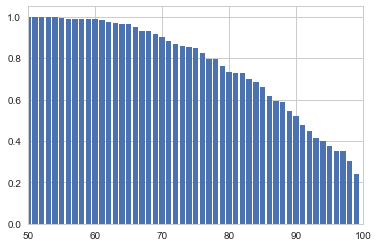

In [42]:
cutoff = np.empty(100)
for i in np.arange(100):
    cutoff[i] = len(datan[datan['bal_accuracy']>=i/100])/len(datan)
plt.bar(np.arange(len(cutoff)),cutoff)
plt.xlim(50,100)
plt.show()

In [43]:
149./165

0.9030303030303031